In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

from epftoolbox.evaluation import MAE, sMAPE
from sklearn.metrics import mean_absolute_percentage_error
from epftoolbox.models import hyperparameter_optimizer

In [79]:
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_lear.py
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_dnn.py

## Caricamento dati

In [6]:
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/Prezzi"

path_2020 = "/Anno2020/Anno 2020_12.xlsx"
path_2021 = "/Anno2021/Anno 2021_12.xlsx"
path_2022 = "/Anno2022/Anno 2022_12.xlsx"

path_2023 = "/Anno2023/Anno 2023_12.xlsx"
path_2024 = "/Anno2024/Anno 2024_08.xlsx"


In [7]:
prezzi2020_df = pd.read_excel(path+path_2020, sheet_name="Prezzi-Prices")
prezzi2021_df = pd.read_excel(path+path_2021, sheet_name="Prezzi-Prices")
prezzi2022_df = pd.read_excel(path+path_2022, sheet_name="Prezzi-Prices")

prezzi2023_df = pd.read_excel(path+path_2023, sheet_name="Prezzi-Prices")
prezzi2024_df = pd.read_excel(path+path_2024, sheet_name="Prezzi-Prices")

In [8]:
# Prezzi 20-22 
prezzi2020_df = prezzi2020_df.iloc[:, :3]
prezzi2021_df = prezzi2021_df.iloc[:, :3]
prezzi2022_df = prezzi2022_df.iloc[:, :3]

prezzi_20_21 = pd.concat([prezzi2020_df, prezzi2021_df])
train_df = pd.concat([prezzi_20_21, prezzi2022_df])

# Prezzi 23-24
prezzi2023_df = prezzi2023_df.iloc[:,:3]
prezzi2024_df = prezzi2024_df.iloc[:, :3]

test_df = pd.concat([prezzi2023_df, prezzi2024_df])




In [9]:
# Riformattiamo gli indici (per evitare duplicati)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [10]:
train_df.index.duplicated().sum(), test_df.index.duplicated().sum()


(0, 0)

In [11]:
train_df.iloc[0:50, :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
0,20200101,1,41.88000
1,20200101,2,38.63858
2,20200101,3,36.55000
3,20200101,4,32.31772
4,20200101,5,30.85000
5,20200101,6,30.13762
6,20200101,7,30.16953
7,20200101,8,30.00000
8,20200101,9,30.65000
9,20200101,10,30.65000


In [12]:
# Riportiamo le ore a 0 - 23 piuttosto che 1-24
train_df['Ora\n/Hour'] = train_df['Ora\n/Hour'].apply(lambda x: x - 1)
test_df['Ora\n/Hour'] = test_df['Ora\n/Hour'].apply(lambda x: x - 1)

In [13]:
# Ci sono tre giorni in cui le ore segnate sono 25 (da 0 a 24) per cui eliminiamo la 24-esima

wrong_dates = train_df['   Data/Date\n(YYYYMMDD)'][train_df['Ora\n/Hour'] > 23]

wrong_indexes = train_df.loc[(train_df['   Data/Date\n(YYYYMMDD)'].isin(list(wrong_dates)) ) & (train_df['Ora\n/Hour'] == 24), :].index

train_df.drop(index=wrong_indexes, inplace=True)

train_df.loc[(train_df['   Data/Date\n(YYYYMMDD)'].isin(list(wrong_dates)) ), :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
7151,20201025,0,35.00000
7152,20201025,1,32.30000
7153,20201025,2,25.00000
7154,20201025,3,24.63000
7155,20201025,4,24.63000
...,...,...,...
24810,20221030,19,170.38178
24811,20221030,20,165.00000
24812,20221030,21,147.52323
24813,20221030,22,139.08159


In [14]:
wrong_dates = test_df['   Data/Date\n(YYYYMMDD)'][test_df['Ora\n/Hour'] > 23] 

wrong_indexes = test_df.loc[(test_df['   Data/Date\n(YYYYMMDD)'].isin(list(wrong_dates)) ) & (test_df['Ora\n/Hour'] == 24), :].index

test_df.drop(index=wrong_indexes, inplace=True)

test_df.loc[(test_df['   Data/Date\n(YYYYMMDD)'].isin(list(wrong_dates)) ), :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
7223,20231029,0,120.39000
7224,20231029,1,105.41000
7225,20231029,2,110.00000
7226,20231029,3,113.00000
7227,20231029,4,103.94000
7228,20231029,5,89.00000
7229,20231029,6,90.00000
7230,20231029,7,114.98000
7231,20231029,8,120.40000
7232,20231029,9,124.78000


In [15]:
train_df['   Data/Date\n(YYYYMMDD)'] = train_df['   Data/Date\n(YYYYMMDD)'].apply(lambda x: str(x))
train_df['Ora\n/Hour'] = train_df['Ora\n/Hour'].apply(lambda x: str(x)).str.zfill(2)

test_df['   Data/Date\n(YYYYMMDD)'] = test_df['   Data/Date\n(YYYYMMDD)'].apply(lambda x: str(x))
test_df['Ora\n/Hour'] = test_df['Ora\n/Hour'].apply(lambda x: str(x)).str.zfill(2)


In [16]:
train_df.iloc[:50, :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
0,20200101,00,41.88000
1,20200101,01,38.63858
2,20200101,02,36.55000
3,20200101,03,32.31772
4,20200101,04,30.85000
5,20200101,05,30.13762
6,20200101,06,30.16953
7,20200101,07,30.00000
8,20200101,08,30.65000
9,20200101,09,30.65000


In [17]:
pd.to_datetime('20200101 01' , format="%Y%m%d %H")

Timestamp('2020-01-01 01:00:00')

In [18]:
# Obiettivo -> riportare in datetime (anno/mese/giorno ora)
train_df['Date'] = train_df['   Data/Date\n(YYYYMMDD)'] + ' ' + train_df['Ora\n/Hour']

train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y%m%d %H")

test_df['Date'] = test_df['   Data/Date\n(YYYYMMDD)'] + ' ' + test_df['Ora\n/Hour']
test_df['Date'] = pd.to_datetime(test_df['Date'], format="%Y%m%d %H")
 

In [19]:
train_df.drop(columns=['   Data/Date\n(YYYYMMDD)', 'Ora\n/Hour'], inplace=True)
test_df.drop(columns=['   Data/Date\n(YYYYMMDD)', 'Ora\n/Hour'], inplace=True)

## Caricamento dati Entso-E

In [20]:
# CARICA I DATI DI ENTSO - E PER GENERAZIONE
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/"

path_gen_2020 = "Generation\ENTSO_E_GEN_2020.xlsx"
path_gen_2021 = "Generation\ENTSO_E_GEN_2021.xlsx"
path_gen_2022 = "Generation\ENTSO_E_GEN_2022.xlsx"

path_gen_2023 = "Generation\ENTSO_E_GEN_2023.xlsx"
path_gen_2024 = "Generation\ENTSO_E_GEN_2024.xlsx"

In [21]:
gen_2020_df = pd.read_excel(path + path_gen_2020).iloc[:, :2]
gen_2021_df = pd.read_excel(path + path_gen_2021).iloc[:, :2]
gen_2022_df = pd.read_excel(path + path_gen_2022).iloc[:, :2]

gen_2023_df = pd.read_excel(path + path_gen_2023).iloc[:, :2]
gen_2024_df = pd.read_excel(path + path_gen_2024).iloc[:, :2] # Fino al 21/09

In [22]:
gen_2020_2021_df = pd.concat([gen_2020_df, gen_2021_df])
train_gen_df = pd.concat([gen_2020_2021_df, gen_2022_df])

test_gen_df = pd.concat([gen_2023_df, gen_2024_df])

In [23]:
# Riformattiamo gli indici (per evitare duplicati)
train_gen_df.reset_index(drop=True, inplace=True)
test_gen_df.reset_index(drop=True, inplace=True)

In [24]:
train_gen_df['Date'] = pd.to_datetime(train_gen_df['MTU'], format="%d.%m.%Y %H:%M ")
test_gen_df['Date'] = pd.to_datetime(test_gen_df['MTU'], format="%d.%m.%Y %H:%M ")

In [25]:
train_gen_df.drop(columns='MTU', inplace=True)
test_gen_df.drop(columns='MTU', inplace=True)

In [26]:
train_gen_df.duplicated("Date").sum(), test_gen_df.duplicated("Date").sum() # Ci sono tre valori duplicati nel train e due nel test
train_gen_df.drop_duplicates('Date', inplace=True), test_gen_df.drop_duplicates("Date", inplace=True)
train_gen_df.duplicated("Date").sum(), test_gen_df.duplicated("Date").sum() 

(0, 0)

In [27]:
# CARICA I DATI DI ENTSO - E PER IL CARICO
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/"

path_load_2020 = "Load\ENTSO_E_LOAD_2020.xlsx"
path_load_2021 = "Load\ENTSO_E_LOAD_2021.xlsx"
path_load_2022 = "Load\ENTSO_E_LOAD_2022.xlsx"

path_load_2023 = "Load\ENTSO_E_LOAD_2023.xlsx"
path_load_2024 = "Load\ENTSO_E_LOAD_2024.xlsx"

In [28]:
load_2020_df = pd.read_excel(path + path_load_2020).iloc[:, :2]
load_2021_df = pd.read_excel(path + path_load_2021).iloc[:, :2]
load_2022_df = pd.read_excel(path + path_load_2022).iloc[:, :2]


load_2023_df = pd.read_excel(path + path_load_2023).iloc[:, :2]
load_2024_df = pd.read_excel(path + path_load_2024).iloc[:, :2] # Fino al 21/09

In [29]:
load_2020_2021_df = pd.concat([load_2020_df, load_2021_df])
train_load_df = pd.concat([load_2020_2021_df, load_2022_df])

test_load_df = pd.concat([load_2023_df, load_2024_df])

In [30]:
# Riformattiamo gli indici (per evitare duplicati)
train_load_df.reset_index(drop=True, inplace=True)
test_load_df.reset_index(drop=True, inplace=True)

In [31]:
train_load_df['Date'] = pd.to_datetime(train_load_df['Time (CET/CEST)'], format="%d.%m.%Y %H:%M ")
test_load_df['Date'] = pd.to_datetime(test_load_df['Time (CET/CEST)'], format="%d.%m.%Y %H:%M ")

In [32]:
train_load_df.drop(columns='Time (CET/CEST)', inplace=True)
test_load_df.drop(columns='Time (CET/CEST)', inplace=True)

In [33]:
train_load_df.duplicated("Date").sum(), test_load_df.duplicated("Date").sum() # Ci sono tre valori duplicati nel train e due nel test
train_load_df.drop_duplicates('Date', inplace=True), test_load_df.drop_duplicates("Date", inplace=True)
train_load_df.duplicated("Date").sum(), test_load_df.duplicated("Date").sum() 

(0, 0)

## CREAZIONE DATASET COMPLETO

In [34]:
train_prices_df = deepcopy(train_df)
test_prices_df = deepcopy(test_df)

In [35]:
########## PROBLEMA TRAIN_SET
# PROBLEMA: il 2022-03-27 ha soltanto 22 valori e non 23 (vedi file Excel) / anche il 2021-03-28 -> serve un imputazione
filtered_df = train_prices_df[train_prices_df['Date'].dt.date == pd.to_datetime('2022-03-27').date()]
filtered_df

# Assegno il prezzo di una settimana prima
new_prices_list = []

new_price_1 = train_prices_df['PUN'][train_prices_df['Date'] == '2022-03-20 23:00'].values[0]
new_price_2 = train_prices_df['PUN'][train_prices_df['Date'] == '2021-03-21 23:00'].values[0]
new_price_3 = train_prices_df['PUN'][train_prices_df['Date'] == '2020-03-22 23:00'].values[0]

new_prices_list.append(new_price_1)
new_prices_list.append(new_price_2)
new_prices_list.append(new_price_3)

dates_list = [pd.to_datetime('2022-03-27 23:00'), pd.to_datetime('2021-03-28 23:00'), pd.to_datetime('2020-03-29 23:00:00')]


new_row = pd.DataFrame({
    'Date': dates_list,
    'PUN': new_prices_list,
})

train_prices_df = pd.concat([train_prices_df, new_row]).sort_index()

In [36]:
########## PROBLEMA TEST_SET
# PROBLEMA: il 2024-03-31 ha soltanto 22 valori (vedi file Excel) -> serve un imputazione
filtered_df = test_prices_df[test_prices_df['Date'].dt.date == pd.to_datetime('2024-03-31').date()]
filtered_df

# Assegno il prezzo di una settimana prima
new_prices_list = []

new_price_1 = test_prices_df['PUN'][test_prices_df['Date'] == '2024-03-24 23:00'].values[0]
new_price_2 = test_prices_df['PUN'][test_prices_df['Date'] == '2023-03-19 23:00'].values[0]

new_prices_list.append(new_price_1)
new_prices_list.append(new_price_2)

dates_list = [pd.to_datetime('2024-03-31 23:00'), pd.to_datetime('2023-03-26 23:00')]


new_row = pd.DataFrame({
    'Date': dates_list,
    'PUN': new_prices_list,
})

test_prices_df = pd.concat([test_prices_df, new_row]).sort_index()

In [37]:
combined_train_df = pd.merge(left=train_prices_df, right=train_gen_df, on='Date', how='inner')
train_df = pd.merge(left=combined_train_df, right=train_load_df, on='Date', how='inner')

combined_test_df = pd.merge(left=test_prices_df, right=test_gen_df, on='Date', how='inner')
test_df = pd.merge(left=combined_test_df, right=test_load_df, on='Date', how='inner')

In [38]:
train_df.rename(columns={'PUN':'Price', 'Scheduled Generation [MW] (D) - Italy (IT)': 'Exogenous 1', 'Day-ahead Total Load Forecast [MW] - Italy (IT)': 'Exogenous 2'}, inplace=True)
test_df.rename(columns={'PUN':'Price', 'Scheduled Generation [MW] (D) - Italy (IT)': 'Exogenous 1', 'Day-ahead Total Load Forecast [MW] - Italy (IT)': 'Exogenous 2'}, inplace=True)

In [39]:
## Imputazione prima feature esogena TRAIN (sostituiamo i valori della scorsa settimana)

nan_dates_ex1 = train_df['Date'][train_df['Exogenous 1'].isna()]
nan_imp_ex1 = nan_dates_ex1 - pd.Timedelta(weeks=1)
imp_ex1 = list(train_df['Exogenous 1'].loc[(train_df['Date'].isin(nan_imp_ex1))])

for i, date_imp in enumerate(nan_dates_ex1):
    train_df.loc[(train_df['Date'] == date_imp), 'Exogenous 1'] = imp_ex1[i]

## Imputazione seconda feature esogena TRAIN (sostituiamo i valori della scorsa settimana)

nan_dates_ex2 = train_df['Date'][train_df['Exogenous 2'].isna()]
nan_imp_ex2 = nan_dates_ex2 - pd.Timedelta(weeks=1)
imp_ex2 = list(train_df['Exogenous 2'].loc[(train_df['Date'].isin(nan_imp_ex2))])

for i, date_imp in enumerate(nan_dates_ex2):
    train_df.loc[(train_df['Date'] == date_imp), 'Exogenous 2'] = imp_ex2[i]


## Imputazione prima feature esogena TEST (sostituiamo i valori della scorsa settimana)

nan_dates_ex1 = test_df['Date'][test_df['Exogenous 1'].isna()]
nan_imp_ex1 = nan_dates_ex1 - pd.Timedelta(weeks=1)
imp_ex1 = list(test_df['Exogenous 1'].loc[(test_df['Date'].isin(nan_imp_ex1))])

for i, date_imp in enumerate(nan_dates_ex1):
    test_df.loc[(test_df['Date'] == date_imp), 'Exogenous 1'] = imp_ex1[i]

## Imputazione seconda feature esogena TEST (sostituiamo i valori della scorsa settimana)

nan_dates_ex2 = test_df['Date'][test_df['Exogenous 2'].isna()]
nan_imp_ex2 = nan_dates_ex2 - pd.Timedelta(weeks=1)
imp_ex2 = list(test_df['Exogenous 2'].loc[(test_df['Date'].isin(nan_imp_ex2))])

for i, date_imp in enumerate(nan_dates_ex2):
    test_df.loc[(test_df['Date'] == date_imp), 'Exogenous 2'] = imp_ex2[i]

In [40]:
train_df = train_df.set_index('Date').sort_index()
test_df = test_df.set_index('Date').sort_index()


## Pre - processing

In [38]:
# Check indice iniziale
if train_df.index[0].hour != 0 or test_df.index[0].hour != 0:
    print('Problem with the index')

In [39]:
# Numero di variabili esogene (tutte tranne il prezzo)
n_exogenous_inputs = len(train_df.columns) - 1

In [40]:
# Features: 96 prices + n_exogenous * (24 * 3 exogeneous) + 7 weekday dummies
# Price lags: D-1, D-2, D-3, D-7
# Exogeneous inputs lags: D, D-1, D-7

n_features = 96 + 7 + n_exogenous_inputs * 72

In [41]:
# Dato che compare il lag D-7 dobbiamo scartare almeno la prima settimana

indexTrain = train_df.loc[train_df.index[0] + pd.Timedelta(weeks=1):].index

In [42]:
indexTrain

DatetimeIndex(['2020-01-08 00:00:00', '2020-01-08 01:00:00',
               '2020-01-08 02:00:00', '2020-01-08 03:00:00',
               '2020-01-08 04:00:00', '2020-01-08 05:00:00',
               '2020-01-08 06:00:00', '2020-01-08 07:00:00',
               '2020-01-08 08:00:00', '2020-01-08 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=26136, freq=None)

In [43]:
# Se impostato su None prende tutti i valori possibili per la previsione, in caso contrario solo i valori da predire per un giorno specifico
date_test = None

if date_test is None:
    indexTest = test_df.loc[test_df.index[0] + pd.Timedelta(weeks=1):].index
else:
    indexTest = test_df.loc[date_test:date_test + pd.Timedelta(hours=23)].index

In [44]:
# Seleziono un timestamp ogni 24 -> un valore giornaliero
predDatesTrain = indexTrain.round('1h')[::24]
predDatesTest = indexTest.round('1h')[::24]

In [45]:
# Creiamo due datasets con tante colonne quante ore del giorno

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
for hour in range(24):
    indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
    indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

In [46]:
# Preallocamento della memoria
X_train = np.zeros([indexTrain.shape[0], n_features])
X_test = np.zeros([indexTest.shape[0], n_features])
Y_train = np.zeros([indexTrain.shape[0], 24])

In [47]:
feature_index = 0

In [48]:
# Aggiungere i prezzi storici nei giorni D-1, D-2, D-3 e D-7


for hour in range(24):
    # Lag
    for past_day in [1, 2, 3, 7]:

        # definiamo gli indici temporali utilizzando dataframes di appoggio
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)]) - pd.Timedelta(hours=24 * past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24 * past_day)

        # Prezzi storici nei giorni passati all'ora h
        X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Price']
        X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Price']
        feature_index += 1

In [49]:
# Variabili esogene nei giorni D, D-1,  D-7

for hour in range(24):
    for past_day in [1, 7]:
        
        for exog in range(1, n_exogenous_inputs + 1):

            # Definying the corresponding past time indexs using the auxiliary dataframses 
            pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)
            pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)

            # Including the exogenous input at day D-past_day and hour "h" 
            X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Exogenous ' + str(exog)]                    
            X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Exogenous ' + str(exog)]
            feature_index += 1

    # For each of the exogenous inputs we include feature if feature selection indicates it
    for exog in range(1, n_exogenous_inputs + 1):
        
        # Definying the corresponding future time indexs using the auxiliary dataframses 
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Including the exogenous input at day D and hour "h" 
        X_train[:, feature_index] = train_df.loc[futureIndexTrain, 'Exogenous ' + str(exog)]        
        X_test[:, feature_index] = test_df.loc[futureIndexTest, 'Exogenous ' + str(exog)] 
        feature_index += 1

In [50]:
# Aggiungiamo le variabily dummy

for dayofweek in range(7):
    X_train[indexTrain.index.dayofweek == dayofweek, feature_index] = 1
    X_test[indexTest.index.dayofweek == dayofweek, feature_index] = 1
    feature_index += 1

    # Estrazione dei valori predetti di y
    for hour in range(24):
        # Definizione degli indici di tempo all'ora h
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Estrazione dei valori di Y basandoci sugli indici di tempo
        Y_train[:, hour] = train_df.loc[futureIndexTrain, 'Price']

In [51]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer()
# imputer.fit(X_train)

# X_train = imputer.transform(X_train)
# X_test = imputer.transform(X_test)

## Model definition / Training / Prediction

In [52]:
model = LEAR()

model.recalibrate(X_train, Y_train)

In [53]:
Y_test_pred = model.predict_days(X_test)

### Test/pred comparison

In [54]:
Y_test_pred

array([[170.23380912, 166.3669941 , 157.45261639, ..., 183.76036615,
        167.68194639, 155.22855384],
       [143.92141532, 135.72793103, 129.416706  , ..., 165.57791175,
        152.50257981, 147.92520473],
       [123.17920024,  96.17240171,  82.10009207, ..., 157.75268295,
        150.67867321, 140.95838516],
       ...,
       [133.16349788, 122.73322204, 119.23084687, ..., 172.92208503,
        149.24786729, 143.52689055],
       [124.19673266, 116.99084239, 111.58583336, ..., 159.02916853,
        135.78999097, 131.78199209],
       [125.18222806, 115.1956189 , 108.92229068, ..., 145.11597222,
        124.20666438, 119.8032055 ]])

In [55]:
excluded_days = test_df['Price'].shape[0] - (Y_test_pred.shape[0] * Y_test_pred.shape[1]) # 168 = 24 * 7 -> giorni esclusi


In [56]:
test_prices_list  = []

true_prices = test_df['Price'].iloc[excluded_days:]

In [57]:
for i in range(0, len(true_prices),24):
    test_prices_list.append(np.array(true_prices[i:24+i]))

In [58]:
Y_test = np.vstack(test_prices_list)

In [59]:
start_test_date = test_df.index[excluded_days] 
end_test_date = start_test_date + pd.Timedelta(days=X_test.shape[0]-1)
prediction_dates = pd.date_range(start=start_test_date, end=end_test_date, freq="D")

In [60]:
for i in range(0, 10):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test[i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test_pred[i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(list(indexTest.index)[i])
    plt.grid(True)
    plt.show()

NameError: name 'time_index' is not defined

<Figure size 1200x600 with 0 Axes>

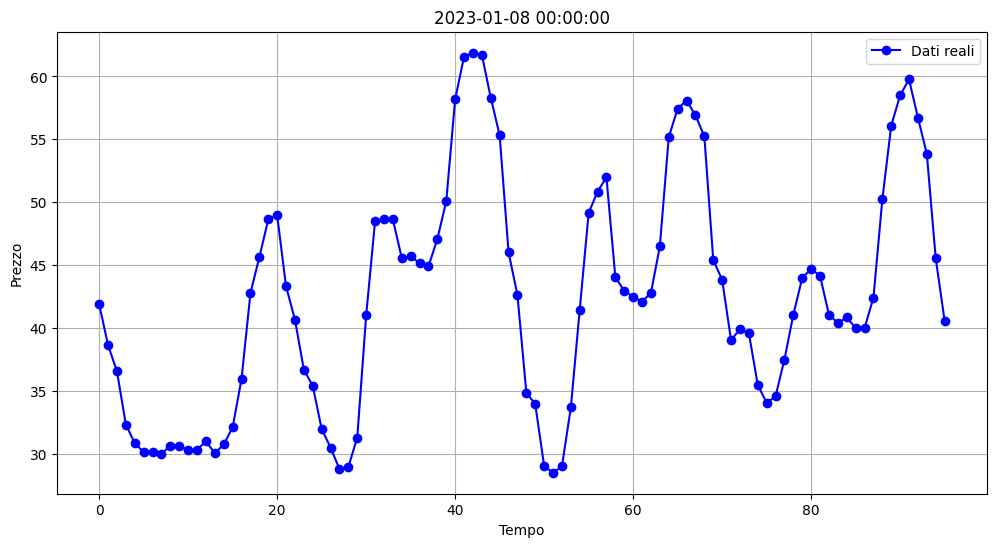

In [2071]:
# PLOT DATI DI TRAIN
time_index = np.arange(24*4)

for i in range(0, 1):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, train_df['Price'].iloc[i:i+24*4], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(list(indexTest.index)[i])
    plt.grid(True)
    plt.show()

In [1929]:
Y_test.shape
Y_test_pred.shape
indexTest.shape

(602, 24)

## Metrics computation

In [1930]:
MAE_LEAR = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_LEAR = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_LEAR = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [1931]:
MAE_LEAR, sMAPE_LEAR, MAPE_LEAR

(11.118741044980622, 0.10834606590036874, 0.17593744696143232)

# DNN

In [41]:
path_dataset = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP"
test_start_date = pd.to_datetime('2023-01-01 00:00:00')
test_end_date = pd.to_datetime('2024-08-31 23:00:00')

In [42]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = 'IT'

# Number of years (a year is 364 days) in the test dataset.
years_test = len(test_df)/364

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = test_start_date
end_test_date = test_end_date

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = len(train_df)/364

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 10

path_datasets_folder = path_dataset
path_hyperparameters_folder = path +  "/experimental_files/"

## DON'T RUN AGAIN

In [80]:
# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2023-01-01 00:00:00 - 2024-08-31 23:00:00


KeyboardInterrupt: 

In [43]:
import pickle as pc

# Percorso dove è stato salvato il file di ottimizzazione
trials_file_path = os.path.join(path_hyperparameters_folder, 'DNN_hyperparameters_nl' + str(nlayers) +
                                '_dat' + str(dataset) + '_YT' + str(years_test) + 
                                '_SF' * shuffle_train + '_DA' * data_augmentation + 
                                '_CW' + str(calibration_window) + '_' + str(experiment_id))

# Caricare il file di trials salvato
with open(trials_file_path, "rb") as f:
    trials = pc.load(f)

In [44]:
# Miglior risultato dato dall'ottimizzatore
trials.best_trial

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': 25.18340289298555,
  'MAE Val': 25.18340289298555,
  'MAE Test': 17.168305996049394,
  'sMAPE Val': 18.443291390590243,
  'sMAPE Test': 16.224729767166483,
  'status': 'ok'},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'In: Day': [0],
   'In: Exog-1 D': [0],
   'In: Exog-1 D-1': [0],
   'In: Exog-1 D-7': [0],
   'In: Exog-2 D': [0],
   'In: Exog-2 D-1': [0],
   'In: Exog-2 D-7': [0],
   'In: Price D-1': [0],
   'In: Price D-2': [0],
   'In: Price D-3': [0],
   'In: Price D-7': [0],
   'activation': [0],
   'batch_normalization': [0],
   'dropout': [0],
   'init': [0],
   'lambdal1': [],
   'lr': [0],
   'neurons1': [0],
   'neurons2': [0],
   'reg': [0],
   'scaleX': [0],
   'scaleY': [0],
   'seed': [0]},
  'vals': {'In: Day': [1],
   'In: Exog-1 D': [0],
   'In: Exog-1 D-1': [1],
   'In: Exog-1 D-7': [0],
   'In: Exog-2 D': [0],
   'In: Exog-2 D-1': [0],
   'In: Exog-2 

In [45]:
# # Parametri migliori per la migliore configurazione
best_trial = trials.best_trial

In [46]:
# Questa funzione del toolbox mette in automatico i parametri di ottimizzazione nel formato richiesto (dizionario) per il modello
opt_hyperparams = format_best_trial(best_trial)

In [47]:
opt_hyperparams

{'In: Day': 1,
 'In: Exog-1 D': 0,
 'In: Exog-1 D-1': 1,
 'In: Exog-1 D-7': 0,
 'In: Exog-2 D': 0,
 'In: Exog-2 D-1': 0,
 'In: Exog-2 D-7': 0,
 'In: Price D-1': 0,
 'In: Price D-2': 1,
 'In: Price D-3': 0,
 'In: Price D-7': 1,
 'activation': 'softplus',
 'batch_normalization': 1,
 'dropout': 0.8346876817795704,
 'init': 'glorot_uniform',
 'lambdal1': 0,
 'lr': 0.0027988003473657344,
 'neurons1': 225.0,
 'neurons2': 136.0,
 'reg': None,
 'scaleX': 'Median',
 'scaleY': 'Norm1',
 'seed': 396.0}

### From dataframe to dataset (array)
* Dataframe: Price, Ex 1 ed Ex 2 aggregate per data/ora
* Dataset: Variabili sviluppate ossia ogni riga è un giorno e per ogni riga vengono considerate le variabili ottenute dalla Bayesian Optimization a livello orario (nota che comprende i lag e che i dati iniziano dal lag massimo + 1) e che non abbiamo 247 valori ma meno.

train_df.shape[0]/24 - (X_train.shape[0] + X_val.shape[0]) = 7 -> massimo lag 

In [48]:
# Metodo per passare da dataframe a dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
    _build_and_split_XYs(dfTrain=train_df,dfTest=test_df,  features=opt_hyperparams, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
                        date_test=None, hyperoptimization=True, data_augmentation=False)

## Model definition

In [49]:
best_trial

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': 25.18340289298555,
  'MAE Val': 25.18340289298555,
  'MAE Test': 17.168305996049394,
  'sMAPE Val': 18.443291390590243,
  'sMAPE Test': 16.224729767166483,
  'status': 'ok'},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'In: Day': [0],
   'In: Exog-1 D': [0],
   'In: Exog-1 D-1': [0],
   'In: Exog-1 D-7': [0],
   'In: Exog-2 D': [0],
   'In: Exog-2 D-1': [0],
   'In: Exog-2 D-7': [0],
   'In: Price D-1': [0],
   'In: Price D-2': [0],
   'In: Price D-3': [0],
   'In: Price D-7': [0],
   'activation': [0],
   'batch_normalization': [0],
   'dropout': [0],
   'init': [0],
   'lambdal1': [],
   'lr': [0],
   'neurons1': [0],
   'neurons2': [0],
   'reg': [0],
   'scaleX': [0],
   'scaleY': [0],
   'seed': [0]},
  'vals': {'In: Day': [1],
   'In: Exog-1 D': [0],
   'In: Exog-1 D-1': [1],
   'In: Exog-1 D-7': [0],
   'In: Exog-2 D': [0],
   'In: Exog-2 D-1': [0],
   'In: Exog-2 

In [50]:
model = DNN(experiment_id=1, path_hyperparameter_folder=path_hyperparameters_folder, nlayers=2,
            dataset='IT', years_test=years_test, shuffle_train=1, data_augmentation=0, calibration_window=calibration_window) 

In [51]:
# NOTA: in questo caso il metodo di regolarizzazione è scelto a priori dall'ottimizzatore degli iperparametri
X_train_reg, X_val_reg, X_test_reg, Y_train_reg, Y_val_reg = model._regularize_data(X_train, X_val, X_test, Y_train, Y_val)

In [52]:
model.recalibrate(X_train_reg, Y_train_reg, X_val_reg, Y_val_reg)

In [53]:
Y_test_pred = model.predict(X_test_reg)

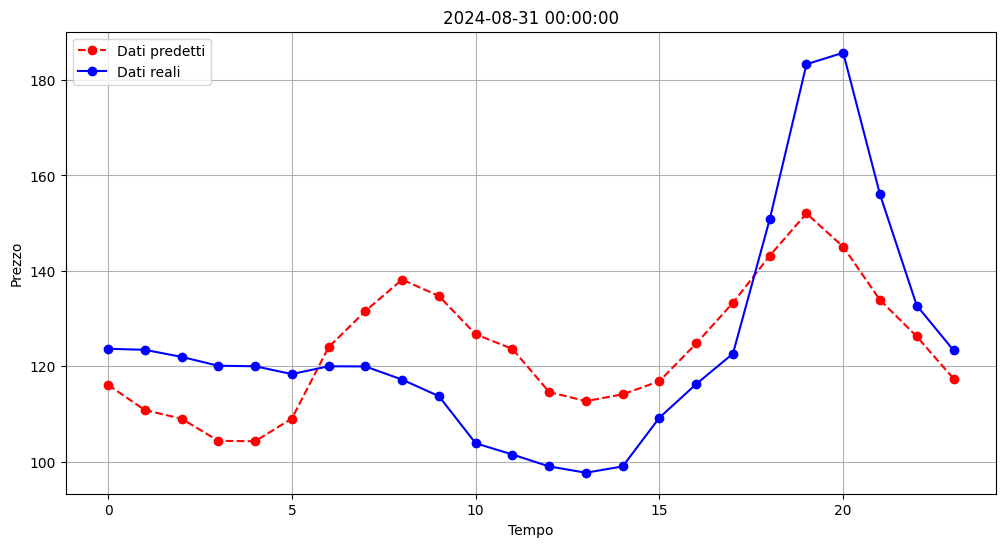

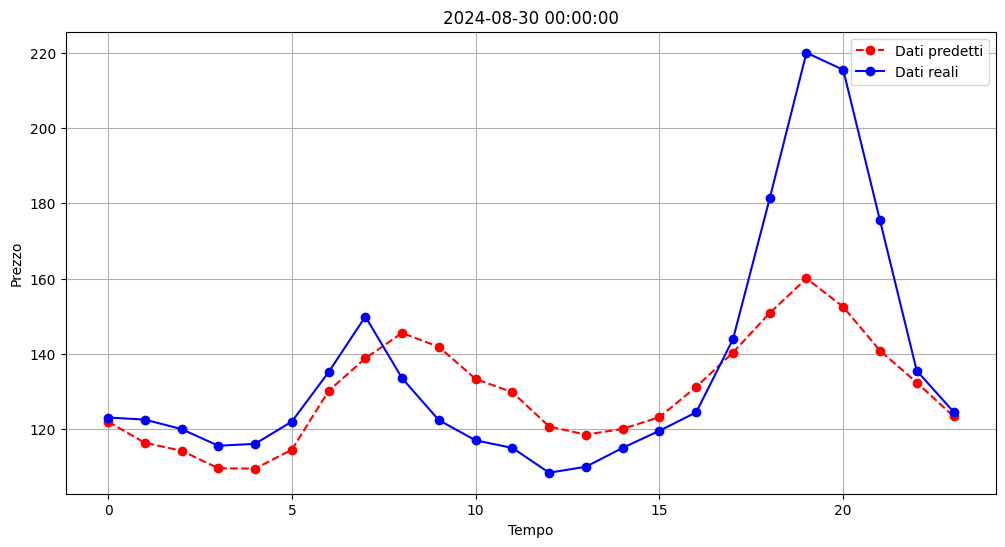

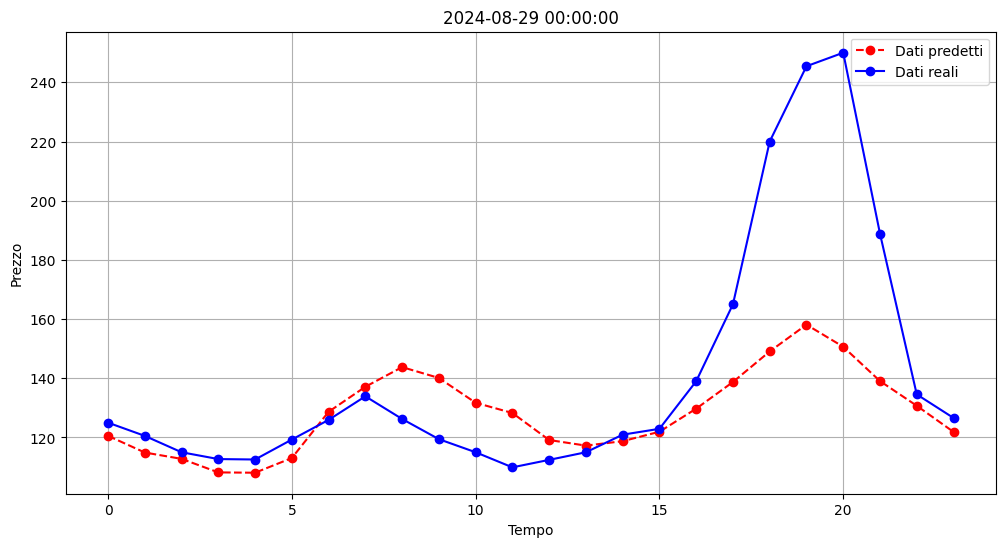

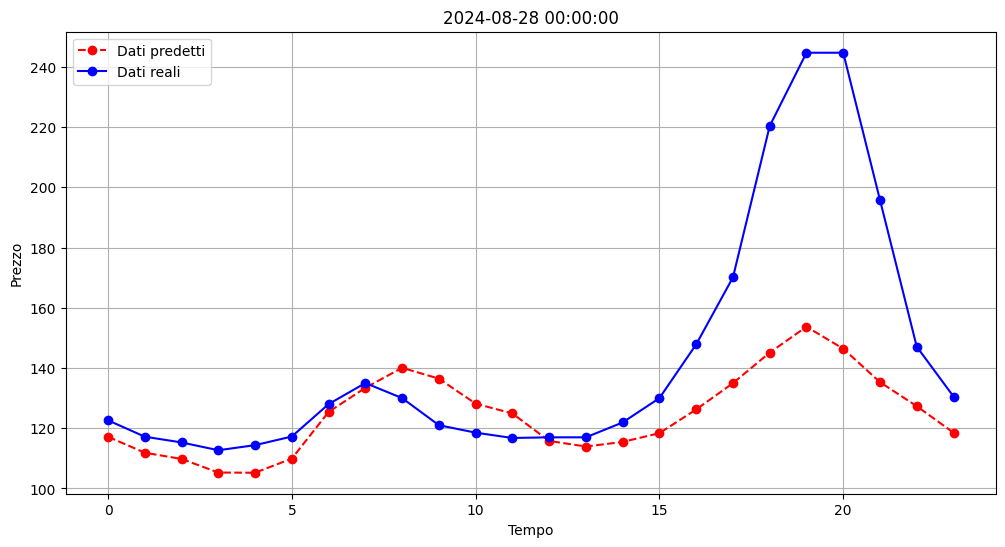

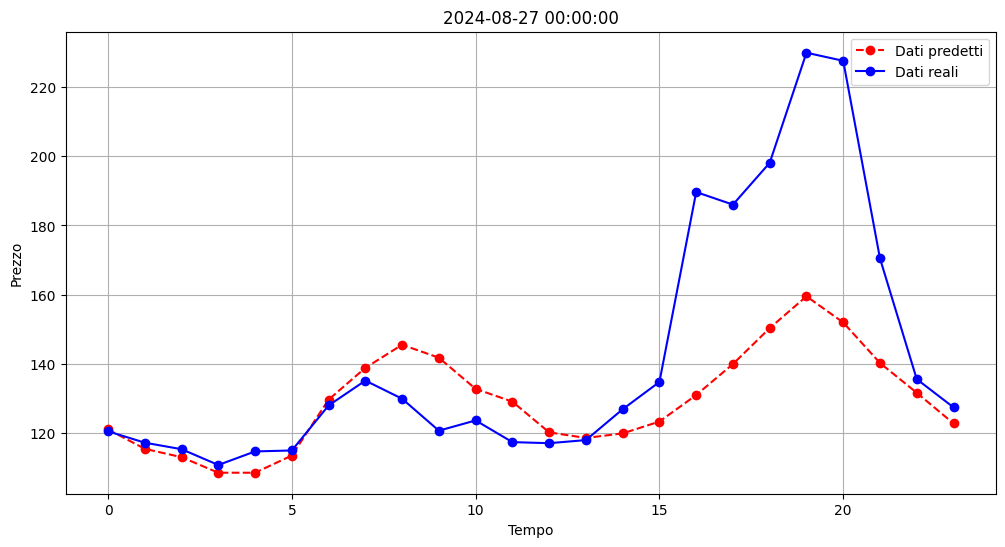

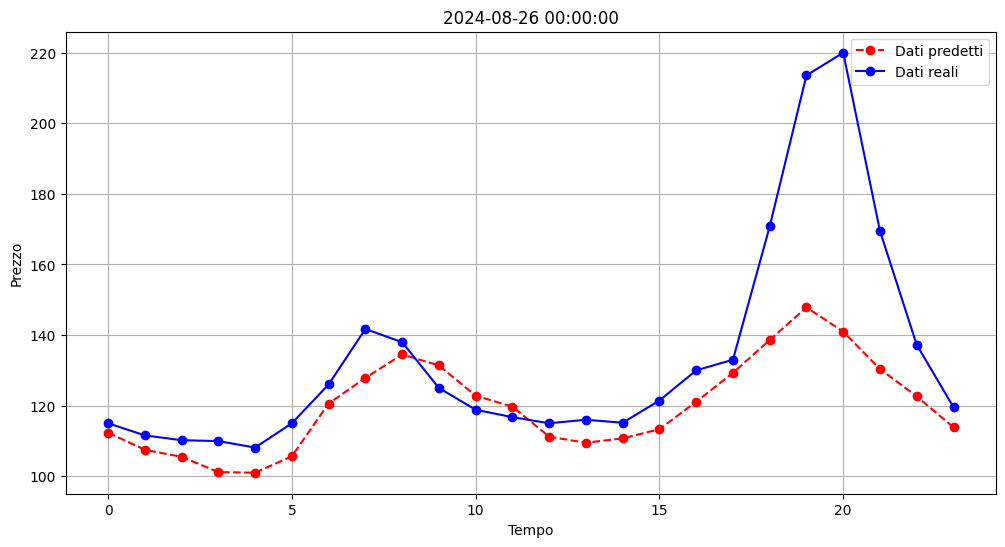

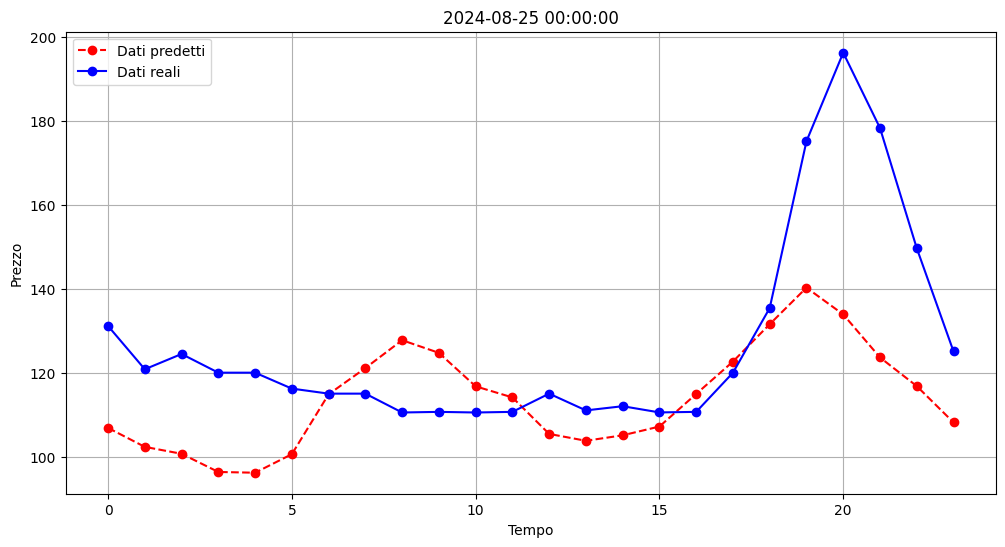

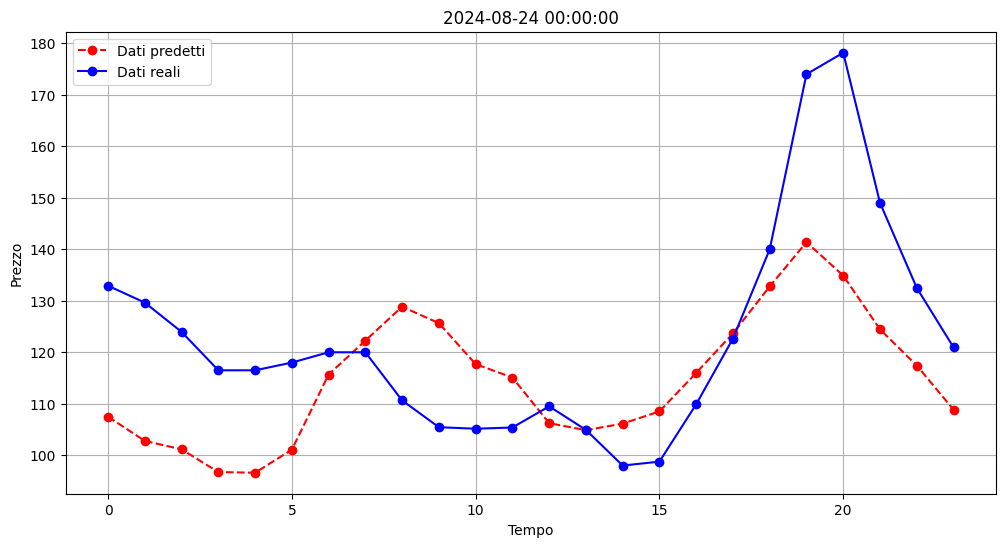

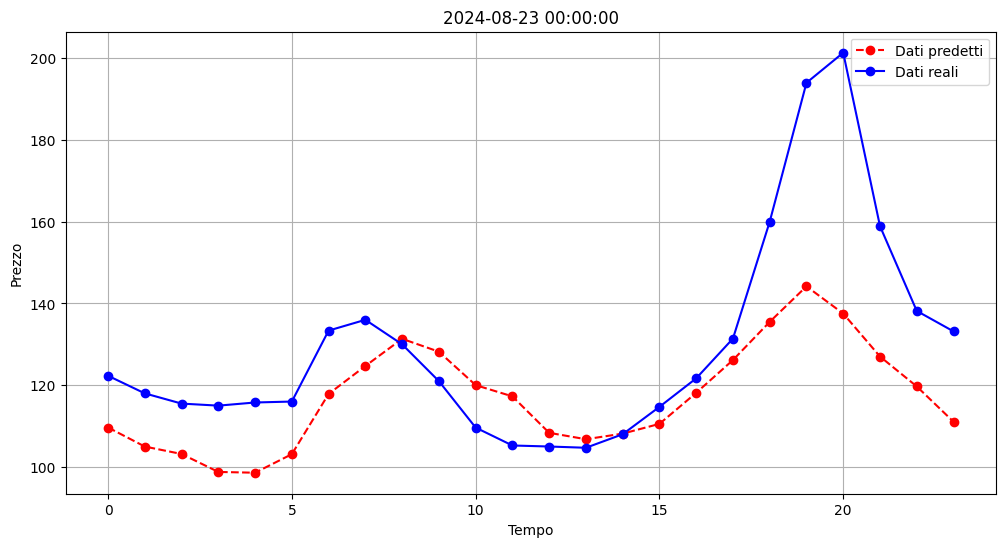

In [55]:
time_index = np.arange(24)


for i in range(1, 10):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test_pred[-i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test[-i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(str(indexTest[-i]))
    plt.grid(True)
    plt.show()

### Metrics computation

In [56]:
MAE_DNN = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_DNN = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_DNN = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [57]:
MAE_DNN, sMAPE_DNN, MAPE_DNN

(16.461534671161353, 0.15692275820364926, 0.2665327002550828)

## DNN model

In [71]:
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP"
train_df, test_df = read_data(path, dataset = "IT") # Grouped dataframes (by date)

In [72]:
features = {}
for key in list(opt_hyperparams.keys())[0:11]:
    features[key] = 1

In [60]:
# NOTA: si consiglia di utilizzare almeno un anno di test,
# possibilità di regolare gli anni di train e test

# train_years = 1
# test_years = 1
# train_df = train_df.iloc[-365*train_years*24:, :]
# test_df = test_df.iloc[:round(365*test_years)*24, :]

In [73]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
    _build_and_split_XYs(dfTrain=train_df,dfTest=test_df,  features=features, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
                        date_test=None, hyperoptimization=True, data_augmentation=False)

In [76]:
# In questo caso lo scaling è effettuato normalizzando i dati rispetto alla norma-2
from epftoolbox.data import DataScaler
from sklearn.preprocessing import StandardScaler


scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train_norm = scaler_x.transform(X_train)
X_val_norm = scaler_x.transform(X_val)
X_test_norm = scaler_x.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(Y_train)
Y_train_norm = scaler_y.transform(Y_train)
Y_val_norm = scaler_y.transform(Y_val)

In [63]:
train_df.iloc[-100:, :]

,Price,Exogenous 1,Exogenous 2
Date,,,
2022-08-30 20:00:00,870.00000,34584.0,41286.0
2022-08-30 21:00:00,866.60273,32776.0,39120.0
2022-08-30 22:00:00,743.09190,29547.0,35591.0
2022-08-30 23:00:00,692.10799,27180.0,32609.0
2022-08-31 00:00:00,576.02000,21005.0,30456.0
...,...,...,...
2022-09-03 19:00:00,529.99616,24891.0,31920.0
2022-09-03 20:00:00,575.66000,25204.0,32928.0
2022-09-03 21:00:00,489.79108,23722.0,30917.0


In [77]:
neurons = [300, 300, 300]
n_features = X_train.shape[1]
dropout = 0.5

# Scaler = None perchè normalizziamo noi prima
# Lamba_reg è il termine di regolarizzazione

model_dnn = DNNModel(neurons=neurons, n_features= n_features, dropout=dropout, batch_normalization=True, scaler=None, lambda_reg=None)

In [78]:
X_train_norm

array([[-5.03104774e-01,  5.40434131e-01,  3.88002027e-01, ...,
         4.17350236e-03, -5.27041471e-01,  7.63540097e-02],
       [-1.37836924e-03,  3.90655295e-01,  5.46307423e-01, ...,
         3.68118563e-02, -7.27968716e-01,  3.27690149e-01],
       [ 5.00348036e-01,  6.28106636e-01,  3.96122095e-01, ...,
        -3.35318884e-01, -1.03060329e+00, -1.46187450e-02],
       ...,
       [-5.03104774e-01, -7.80916199e-01, -8.44954841e-01, ...,
         5.58757991e-01, -5.24994067e-02,  7.76270519e-01],
       [-1.37836924e-03, -8.34091269e-01, -7.78628976e-01, ...,
         7.29975586e-01,  5.65285360e-04,  5.01713106e-01],
       [ 5.00348036e-01, -8.39394443e-01, -8.31948361e-01, ...,
         6.34200744e-01, -2.91843278e-01,  7.60425414e-01]])

In [65]:
model_dnn.fit(X_train_norm, Y_train_norm, X_val_norm, Y_val_norm)

In [66]:
Y_test_pred_norm = model_dnn.predict(X_test_norm)

In [67]:
Y_test_pred = scaler_y.inverse_transform(Y_test_pred_norm)

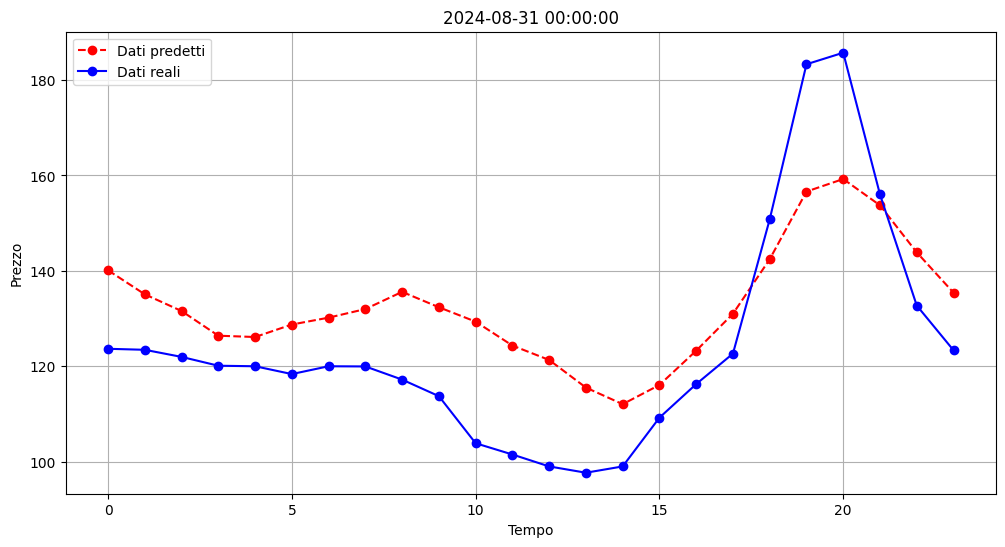

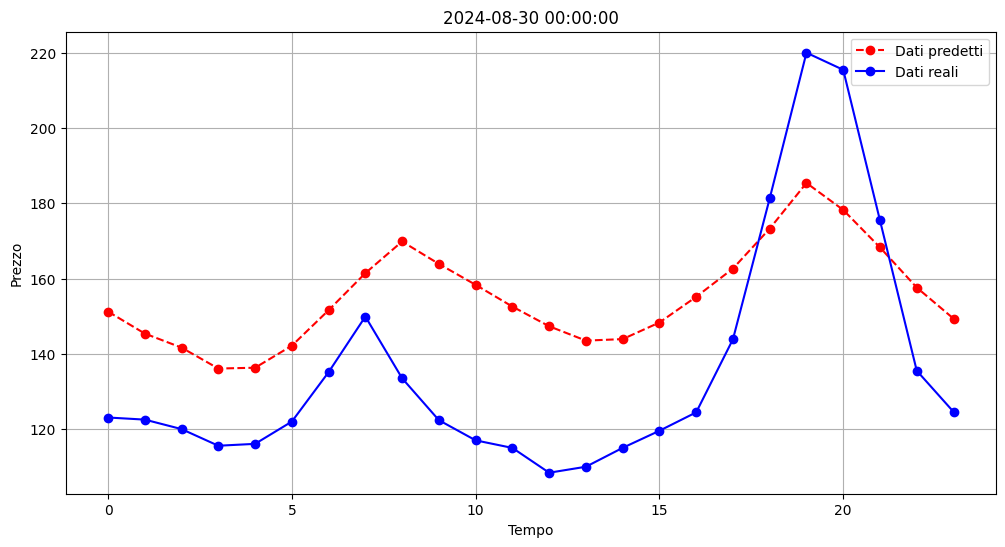

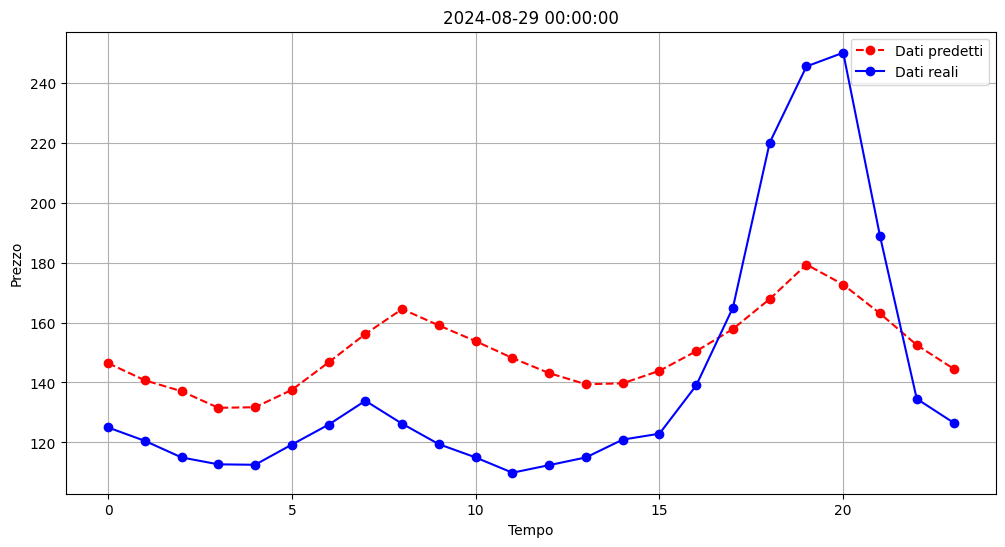

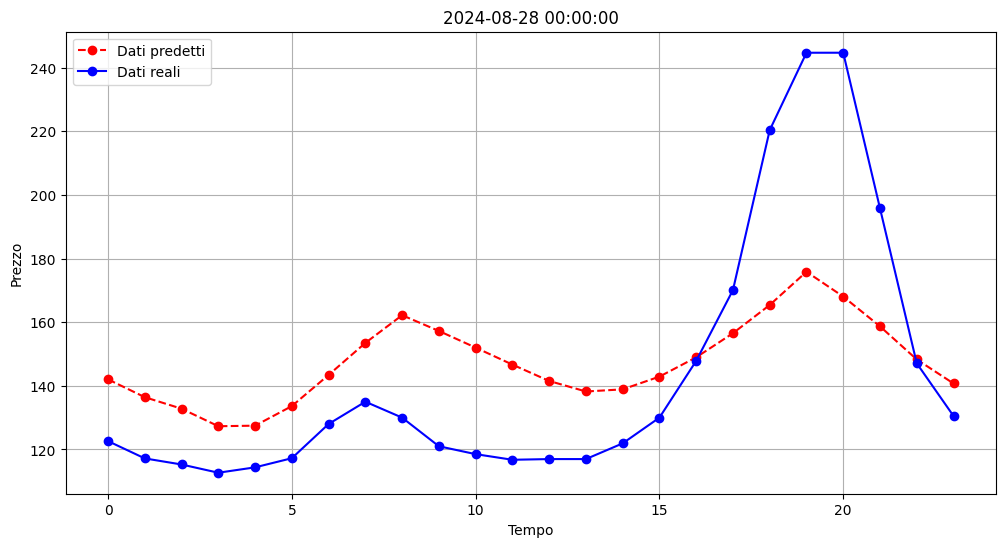

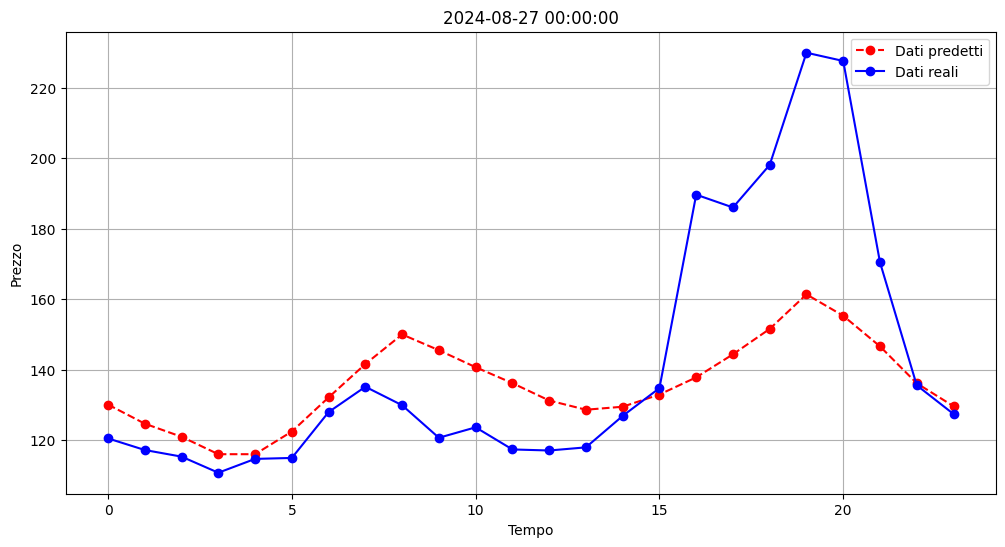

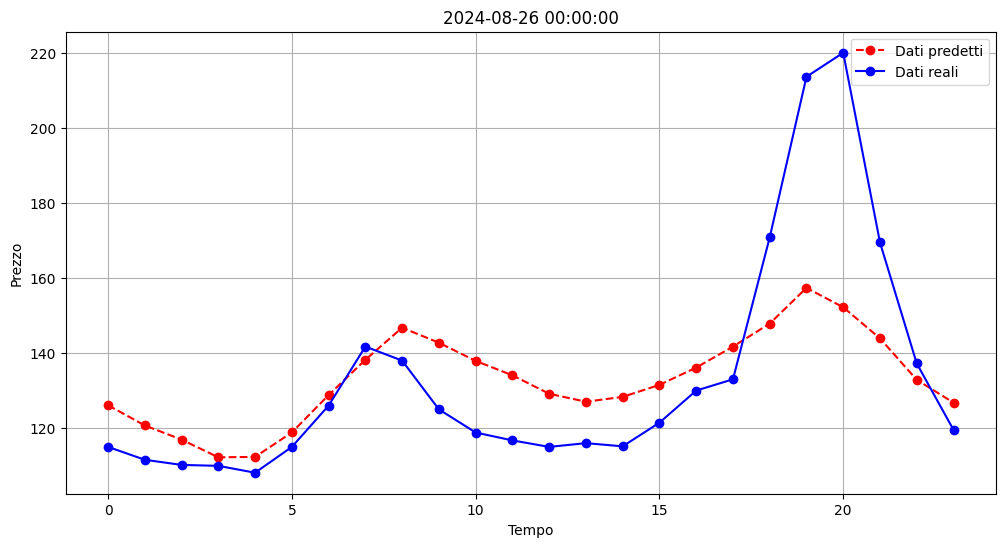

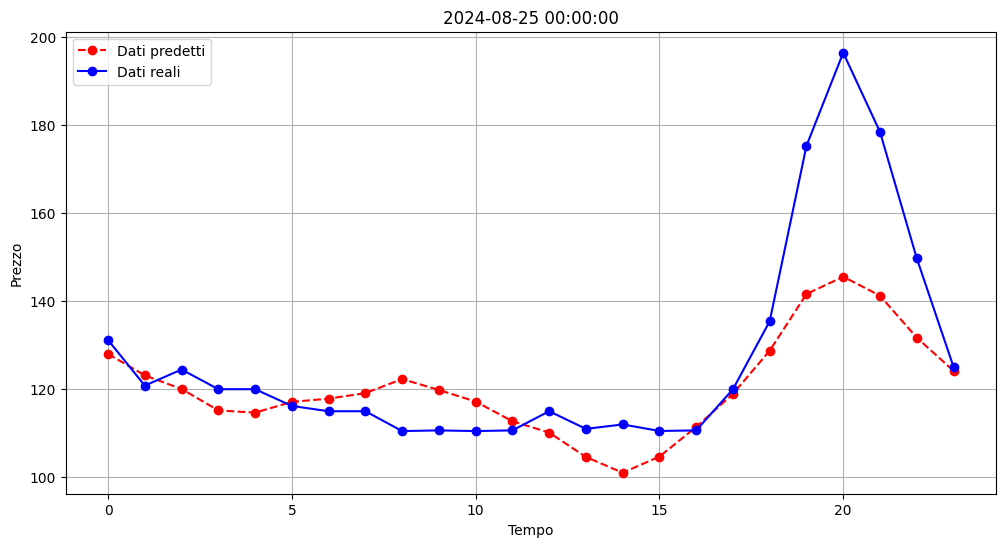

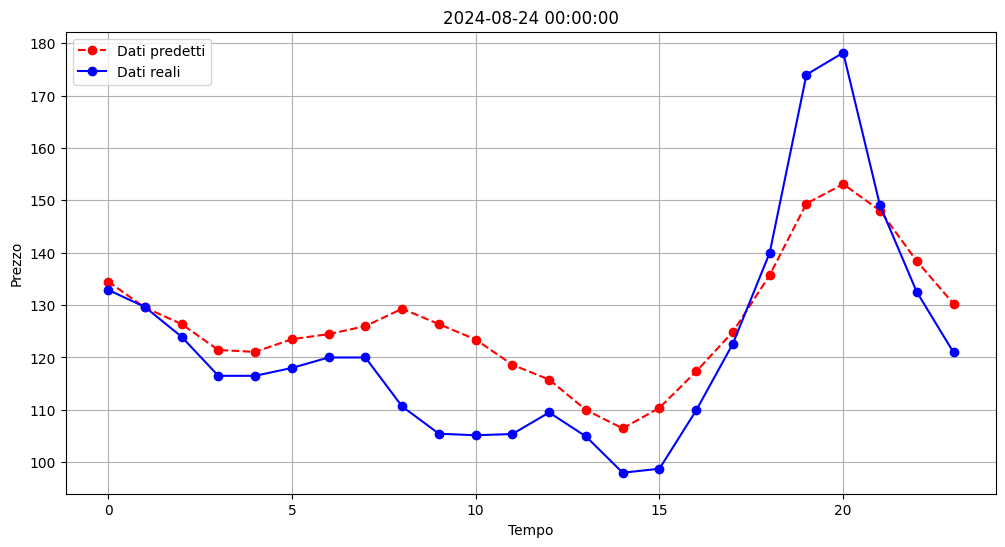

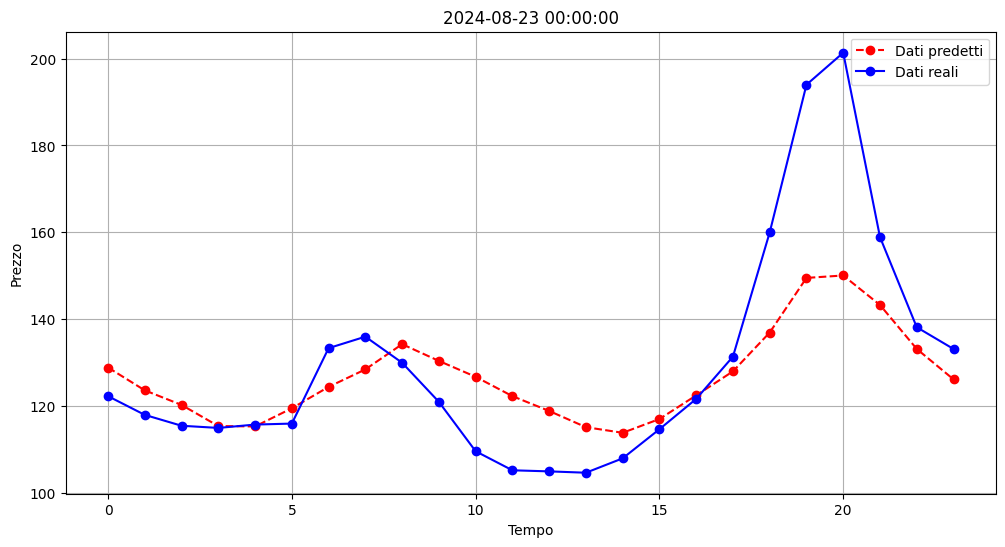

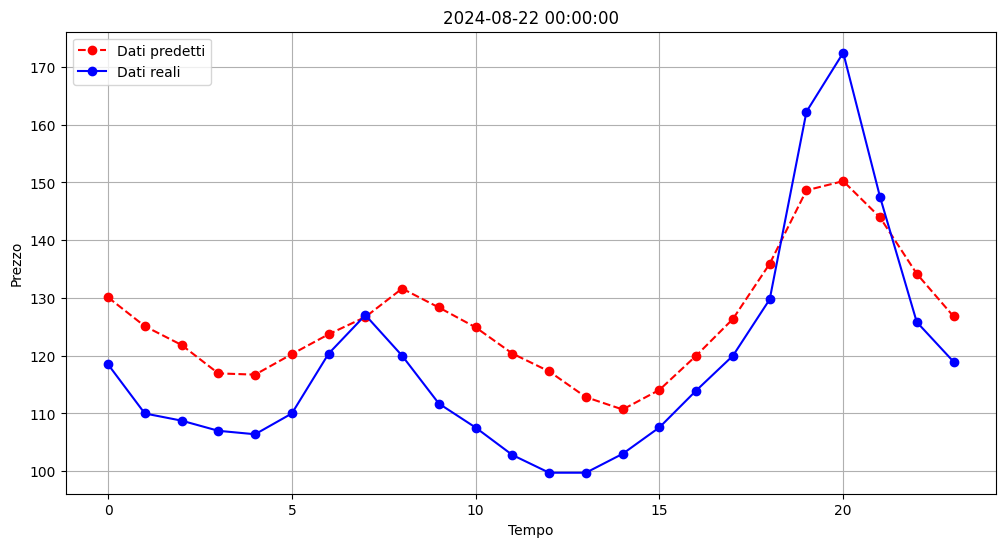

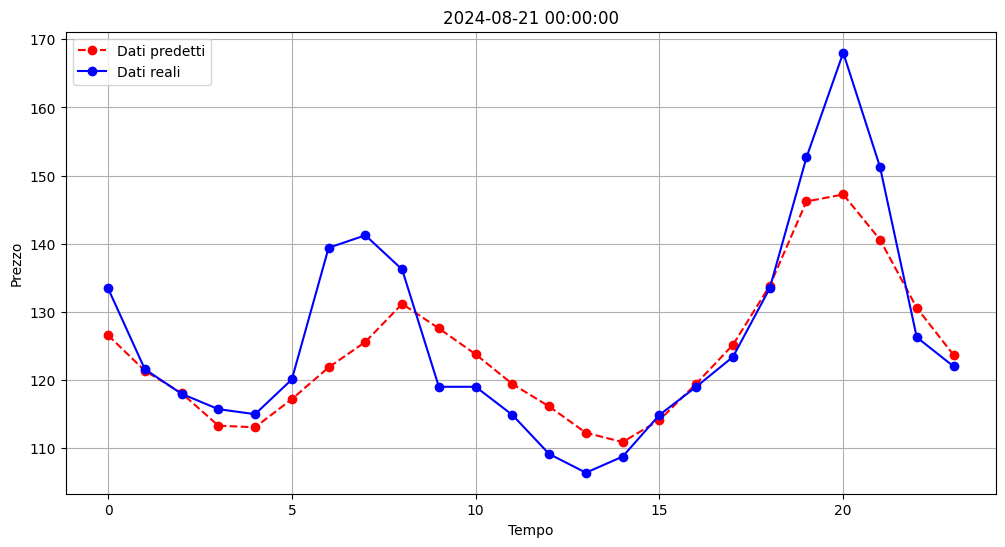

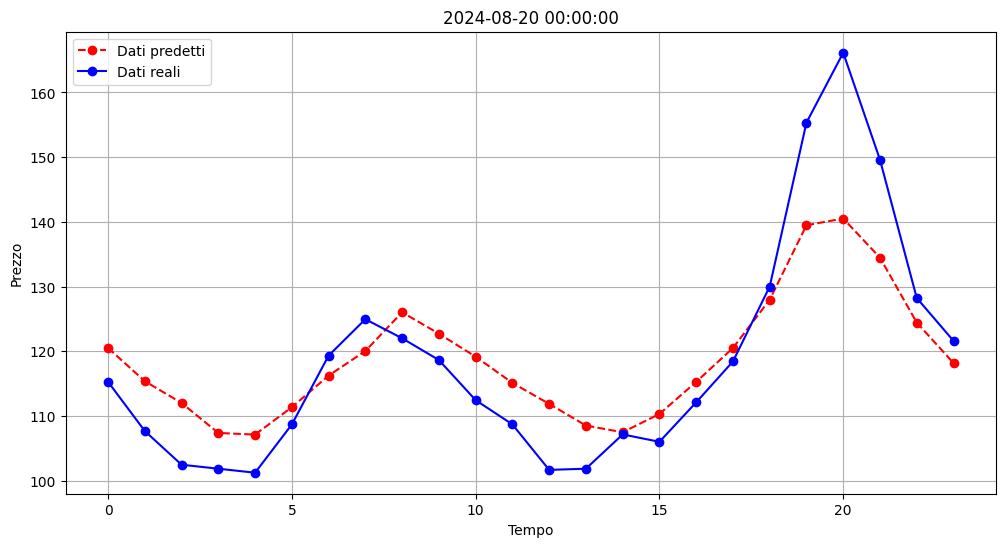

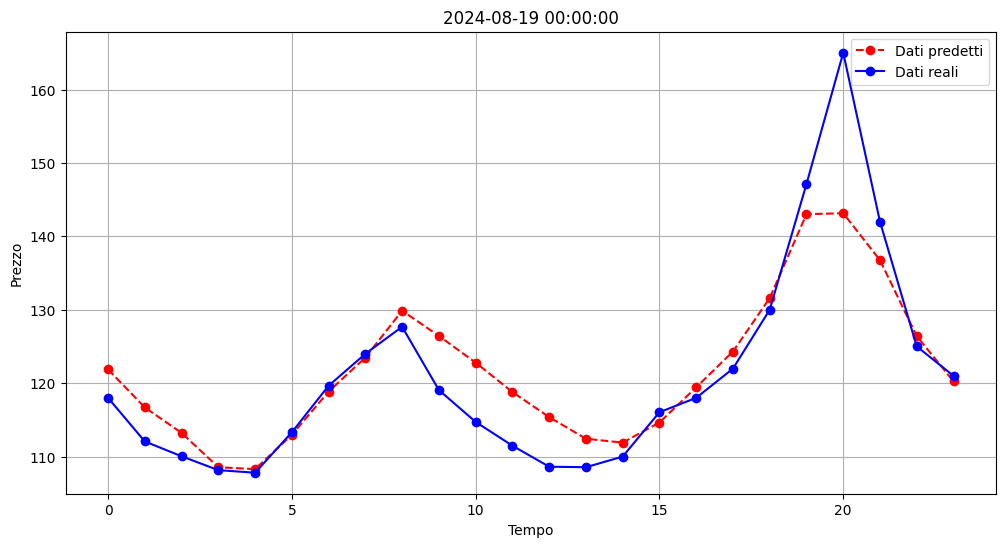

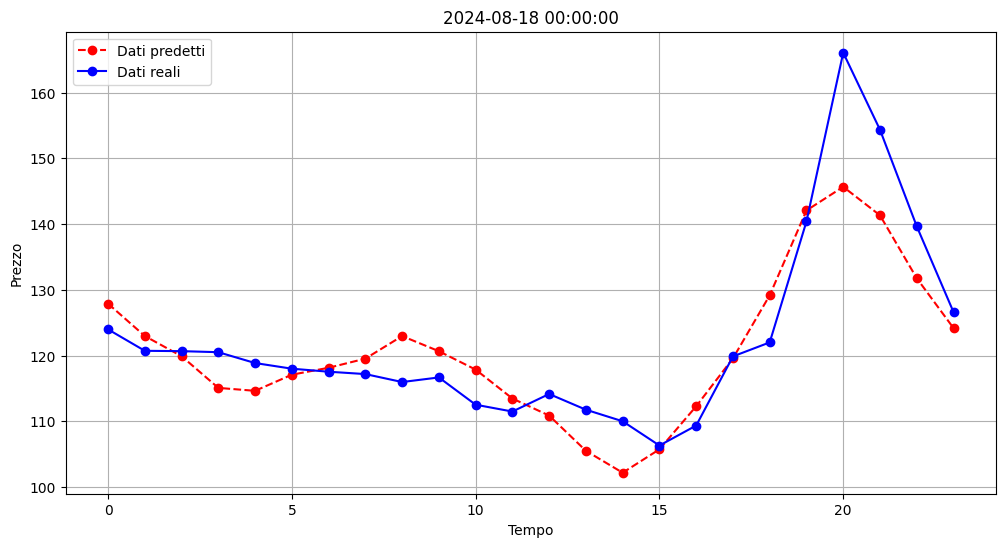

In [68]:
time_index = np.arange(24)

for i in range(1, 15):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test_pred[-i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test[-i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(str(indexTest[-i]))
    plt.grid(True)
    plt.show()

### Metrics computation

In [69]:
MAE_DNN = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_DNN = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_DNN = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [70]:
MAE_DNN, sMAPE_DNN, MAPE_DNN

(17.97791645160613, 0.13692471892015257, 0.23909916688348534)